In [1]:
%matplotlib inline
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyzbar import pyzbar
from scipy.sparse.linalg import lsqr

import cv2 



#this class is to convert image coordinates into a point in 3D space
class calibrator():
    def __init__(self):
        #initialize the camera outside the class the sample code is as follows:
        #pipe = rs.pipeline()
        #config = rs.config()
        #config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
        #config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
        #profile = pipe.start(config)
        
        self.prof = profile.get_stream(rs.stream.depth)
        self.intr = self.prof.as_video_stream_profile().get_intrinsics() #camera intrinsics 
        
    def coords_relative_to_camera(self,coords,depth,intr):
        #this method takes image coordinates and corresponding depth image and maps it to camera coordinate system
        [ix,iy]=coords[1:]
        iz=depth.get_distance(ix, iy)#get depth value the RGB and depth image is to be aligned 
        point=rs.rs2_deproject_pixel_to_point(intr,[ix,iy],iz)
        [Cx,Cy,Cz]=point #convert to centimeters
        Cx=round(Cx*100,2)
        Cy=round(Cy*100,2)
        Cz=round(Cz*100,2)
        point=(coords[0],Cx,Cy,Cz)
        return point
    
    def landmark_measurement(self,image_coords,depth_image,intr):
        #print('image coords=',image_coords)
        width=intr.width
        h=intr.height
        ppx=intr.ppx
        ppy=intr.ppy
        fx=intr.fx
        fy=intr.fy 
        #landmark_id=image_coords[0]
        [ix,iy]=image_coords[:]
        #Zc=depth_image.get_distance(ix, iy)
        Zc=0.5422 # manually entering the distance instead of reading from the depth image, the bug needs to be resolved
        #homography
        P_transf=np.vstack(([Zc/(fx),0,-Zc*ppx/fx],[0,Zc/fy,-Zc*ppy/fy],[0,0,Zc]))
        I=np.transpose([ix,iy,1])
        X=P_transf@I #transform x image_coordinates=camera coordinates
        X[0]=round(X[0]*100,2)
        X[1]=round(X[1]*100,2)
        X[2]=round(X[2]*100,2)
        measurement=[X[0],X[1],X[2]]
        return measurement
    
    def get_Pi_inv(self,landmark_measurements,corners,intr_mat): #function to calculate Pi_inv as per the referred paper
        print('lm shape',landmark_measurements.shape,'corner shape',corners.shape)
        landmark_measurements=np.array(landmark_measurements,dtype=np.float32)
        landmark_measurements=landmark_measurements.reshape(4,3)
        corners=np.array(corners,dtype=np.float32)
        corners=corners.reshape(4,2)
        retval, rvec, tvec,_=cv2.solvePnPRansac(landmark_measurements,corners,np.array(intr_mat),None)
        [rot,jacob]=cv2.Rodrigues(rvec)
        last_row=[0,0,0,1]
        Pi_inv= np.hstack((rot,tvec))
        Pi_inv=np.vstack((Pi_inv,last_row))
        print(Pi_inv)
        return Pi_inv
    
    def QRcode_corners(self,frame):
        #this method is used to detect the center of the QR code in an image,
    
        barcodes = pyzbar.decode(frame)
        centerOfQRs=[]
        landmark_id='NIL'
        corners=[]
        for barcode in barcodes:
            landmark_id=barcode.data.decode()
            x, y , w, h = barcode.rect
            cv2.rectangle(frame, (x, y),(x+w, y+h), (0, 255, 0), 2)
            center=(int(x+w/2),int(y+h/2))
            centerOfQRs.append([landmark_id,center[0],center[1]])
        
            left = barcode.rect[0]
            top = barcode.rect[1]
            width = barcode.rect[2]
            height = barcode.rect[3]
            # get the rectangular contour corner coordinates
            top_left = [top,left]
            top_right = [top,left+width]
            bottom_left = [top-height,left]
            bottom_right = [top-height,left+width]
            corners.append([landmark_id,top_left,top_right,bottom_left,bottom_right])
    
        return frame,centerOfQRs,corners

    def intrinsic_mat(self,intr):
        width=intr.width
        h=intr.height
        ppx=intr.ppx
        ppy=intr.ppy
        fx=intr.fx
        fy=intr.fy 
        intr_mat=np.vstack(([fx,0,ppx],[0,fy,ppy],[0,0,1]))

        return intr_mat
    
    def get_B(self,Pi_inv,Pj_inv):
        #this method calculates B ie, transform from the first camera position to the second camera position
        Pj=np.linalg.inv(Pj_inv)
        B=Pi_inv@Pj
        return B
    
    def decomp_R_t(self,A):
        #function to decompose a matrix in homogenous transformation to rotation and translation matrix
        A=np.array(A)
        R=A[:3,:3]
        t=A[:3,3]
        return R,t
    
    def construct_final_matrices(self,Ai,Bi,Aj,Bj):
        #function to construct the final matrices of eqn 7 in the paper
        Rai,tai= self.decomp_R_t(Ai)
        Rbi,tbi=self.decomp_R_t(Bi)
        Raj,taj= self.decomp_R_t(Aj)
        Rbj,tbj=self.decomp_R_t(Bj)
    
        u=np.hstack((np.identity(9)-np.kron(Rai,Rbi), np.zeros((9,3))))
        v=np.hstack((np.kron(np.identity(3),np.transpose(tbi)),np.identity(3)-Rai))
        w=np.hstack((np.identity(9)-np.kron(Raj,Rbj), np.zeros((9,3))))
        x=np.hstack((np.kron(np.identity(3),np.transpose(tbj)),np.identity(3)-Raj))
        M=np.concatenate((u,v,w,x),axis=0)
    
        tai=tai.reshape(3,1)
        tbi=tbi.reshape(3,1)
        N=np.vstack((np.zeros((9,1)),tai,np.zeros((9,1)),tbi))
        return M,N
    
    def solve_for_x(self,M,N):
        #solves for x in equation 7, uses scipy library's least square method to solve  
        x=lsqr(M,N)
        return x
        
    
    def choose_points(self,image):
        #this method is chiefly to trouble shoot, this method allows for points can be picked manually 
        #on images and returns the list of image coordinates of the points chosen
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(image)
        text=ax.text(0,0, "", va="bottom", ha="left")
        coords=[]
    
        def onclick(event):
            tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
            text.set_text(tx)
            coords.append([event.x,event.y])
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
        return coords

    
    

In [2]:
#set up the realsense camera to get  rgb and depth data
pipe = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
profile = pipe.start(config)

depth_sensor = profile.get_device().first_depth_sensor()
depth_sensor.set_option(rs.option.visual_preset, 3) 



In [3]:
#instantiate the image_to_cam_cord class
mapper=calibrator()


Pi_inv_mat=[]
datalog_flag=False
thresh=1
corner_dict=dict()
while True:
    frameset = pipe.wait_for_frames()
    color_frame = frameset.get_color_frame()
    depth=frameset.get_depth_frame()
    color = np.asanyarray(color_frame.get_data())
    frame,centerOfQRs,corners = mapper.QRcode_corners(color)
    prof = profile.get_stream(rs.stream.depth)
    intr = prof.as_video_stream_profile().get_intrinsics()
    
    try:
        landmark_measurements=[]
        try:
            key=corners[0][0]
            coords1=np.array(corner_dict[key])
            coords2=np.array(corners[0][1:])
            dist=np.linalg.norm(coords1-coords2)
            if dist>thresh:
                print('arm moved')
                datalog_flag=True
        except Exception as e:
            print(e)
            print('i am here')
            if len(corner_dict)==0:
                datalog_flag=True

        for corner in corners:
            print('corner=',corner)
            if datalog_flag==True:
                corner_dict[corner[0]]=corner[1:]
            print(corner_dict)
            for corner_i in corner[1:]:
                [x,y]=corner_i
                landmark_coordinates_current=mapper.landmark_measurement(corner_i,depth,intr)
                print('returns=',landmark_coordinates_current)
                landmark_measurements.append(landmark_coordinates_current)
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, 'landmark measurement='+str(landmark_coordinates_current), (x, y), font, 0.5, (0,0,0), 2)
        #print('lm=',landmark_measurements,'corners=',corners[0][1:])
        landmark_measurements=np.array(landmark_measurements,dtype=np.float32)
        corners=np.array(corners[0][1:],dtype=np.float32)
        print(landmark_measurements.shape)
        print(corners.shape)

        
        intr_mat=mapper.intrinsic_mat(intr)
        if datalog_flag==True:
         if corners.shape[0]==4:
            Pi_inv=mapper.get_Pi_inv(landmark_measurements,corners,intr_mat)
            Pi_inv_mat.append(Pi_inv)
            datalog_flag=False
        
        
    except Exception as e:
        print(e)
        (x,y)=(0,0)
    
    cv2.imshow('Center of the QR Code', frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break
cv2.destroyAllWindows()

list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out of range
i am here
list index out of range
list index out

In [25]:
Ai=np.random.rand(4,4)
Aj=np.random.rand(4,4)
Bi=np.random.rand(4,4)
Bj=np.random.rand(4,4)
M,N=mapper.construct_final_matrices(Ai,Bi,Aj,Bj)
print(M)

[[ 0.97525509 -0.11698599 -0.01567732 -0.02627992 -0.12424301 -0.01664984
  -0.00875617 -0.04139636 -0.00554754  0.          0.          0.        ]
 [-0.24583052  0.56790927 -0.16921327 -0.26108017 -0.45889469 -0.17971011
  -0.08698894 -0.15289849 -0.05987736  0.          0.          0.        ]
 [-0.22643199 -0.33941124  0.80582971 -0.24047829 -0.360466   -0.20621529
  -0.08012463 -0.12010316 -0.06870859  0.          0.          0.        ]
 [-0.00754554 -0.03567289 -0.00478053  0.96754678 -0.15342841 -0.02056098
  -0.02331324 -0.1102175  -0.01477027  0.          0.          0.        ]
 [-0.07496184 -0.13175872 -0.05159871 -0.32240942  0.43330827 -0.22192506
  -0.23160742 -0.40709111 -0.15942304  0.          0.          0.        ]
 [-0.06904659 -0.10349769 -0.05920893 -0.29696805 -0.44514156  0.74534353
  -0.21333124 -0.31977381 -0.18293612  0.          0.          0.        ]
 [-0.0505054  -0.23877331 -0.03199807 -0.03754224 -0.17748765 -0.02378516
   0.9927198  -0.03441844 -0.004

In [9]:
def serializer(motion_list):
    #motion_list=[[A1,B1,A2,B2],......,[Ai,Bi,Aj,Bj],.....]
    M=None
    N=None
    for i in motion_list:
        [Ai,Bi,Aj,Bj]=i
        m,n=mapper.construct_final_matrices(Ai,Bi,Aj,Bj)
        if M is None:
            M=m
            N=n
        else:
            M=np.vstack((M,m))
            N=np.vstack((N,n))
    return M,N

In [10]:
A1=np.random.rand(4,4)
A2=np.random.rand(4,4)
B1=np.random.rand(4,4)
B2=np.random.rand(4,4)
A3=np.random.rand(4,4)
A4=np.random.rand(4,4)
B3=np.random.rand(4,4)
B4=np.random.rand(4,4)
motion_list=[[A1,A2,B1,B2],[A3,A4,B3,B4]]

M,N=serializer(motion_list)
print(M)

[[ 0.97846098 -0.21155607 -0.09641827 -0.01832254 -0.17996378 -0.08201984
  -0.02475877 -0.24318042 -0.1108313   0.          0.          0.        ]
 [-0.17338736  0.52655589 -0.13019585 -0.14749491 -0.4027433  -0.11075331
  -0.19930607 -0.54421666 -0.1496581   0.          0.          0.        ]
 [-0.05431032 -0.27939628  0.56614784 -0.0462     -0.23767321 -0.36906373
  -0.06242887 -0.32116169 -0.49870632  0.          0.          0.        ]
 [-0.00634166 -0.06228769 -0.02838808  0.97901028 -0.20616083 -0.09395935
  -0.02589807 -0.25437061 -0.11593131  0.          0.          0.        ]
 [-0.05104981 -0.13939444 -0.03833309 -0.16896552  0.53862997 -0.12687551
  -0.20847734 -0.56925932 -0.15654477  0.          0.          0.        ]
 [-0.01599039 -0.08226164 -0.12773752 -0.05292526 -0.27227094  0.57721222
  -0.06530159 -0.33594026 -0.52165479  0.          0.          0.        ]
 [-0.01688374 -0.16583189 -0.07557913 -0.0354662  -0.34834864 -0.15876251
   0.9797703  -0.19869588 -0.090

In [11]:
x=mapper.solve_for_x(M,N)
print(x)

(array([ 0.04119378,  0.07342986,  0.10451426, -0.00922654,  0.01815674,
        0.02079397,  0.05172993,  0.01293619,  0.12268369, -0.89422663,
       -0.27811878, -0.57757253]), 2, 12, 1.1164967662328362, 1.1164967662328362, 9.669887479092116, 16.17392602981333, 9.872017461194286e-12, 1.1168416421269476, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


lm1


[[3 4]
 [5 7]]
[[2 2]
 [2 2]]
4.0


image coords= [[194, 375], [194, 628], [-43, 375], [-43, 628]]


ValueError: too many values to unpack (expected 2)

In [61]:
pj_inv=[[ 8.43350127e-01,-2.17423841e-02,5.36924419e-01,-1.70900685e+02],
 [ 3.12193405e-01,-7.93432991e-01,-5.22493413e-01 ,7.15715868e+01],
 [ 4.37373800e-01  ,6.08269149e-01 ,-6.62353985e-01  ,5.65357293e+02],
 [ 0.00000000e+00  ,0.00000000e+00  ,0.00000000e+00  ,1.00000000e+00]]

In [62]:
pi_inv=np.array([[-8.31453656e-01 ,4.20094212e-01 ,3.63600977e-01,-2.72348518e+01],
 [ 3.89441076e-01 ,9.07421557e-01,-1.57866291e-01 ,6.46672105e+00],
 [-3.96258080e-01 ,1.03426512e-02 ,-9.18080913e-01  ,3.41312741e+01],
 [ 0.00000000e+00  ,0.00000000e+00  ,0.00000000e+00  ,1.00000000e+00]])

In [70]:
b=mapper.get_B(pi_inv,pj_inv)
print(b)

[[-5.15114153e-01 -7.82870070e-01 -3.48958253e-01  1.38049133e+02]
 [ 2.23943407e-01 -5.15913167e-01  8.26851228e-01 -3.85802846e+02]
 [-8.27349237e-01  3.47775870e-01  4.41072765e-01 -3.81517852e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [67]:
#the code blocks below are running the dataset we collected, I am loading each image and manually sending the location of one landmark and repeating the process
#for each image
Pi_inv_mat=[]

[['Landmark 1', [237, 156], [237, 281], [105, 156], [105, 281]], ['Landmark 2', [224, 32], [224, 150], [96, 32], [96, 150]], ['Landmark 4', [19, 29], [19, 154], [-123, 29], [-123, 154]], ['Landmark 11', [48, 464], [48, 631], [-106, 464], [-106, 631]], ['Landmark 3', [28, 163], [28, 297], [-118, 163], [-118, 297]]]
returns= [-13.26, -28.93, 54.22]
returns= [-13.26, -12.23, 54.22]
returns= [-31.38, -28.93, 54.22]
returns= [-31.38, -12.23, 54.22]
lm shape (4, 3) corner shape (4, 2)
[[ 9.99999962e-01 -1.30459500e-04  2.44832016e-04 -2.12086072e-01]
 [ 1.30590062e-04  9.99999849e-01 -5.33332555e-04  2.78179590e-01]
 [-2.44762401e-04  5.33364507e-04  9.99999828e-01  2.04864552e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


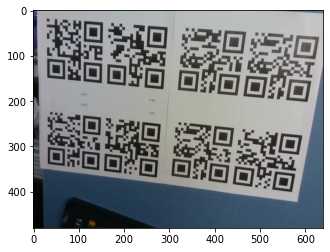

In [74]:
image=cv2.imread('12_Color.png')
depth=cv2.imread('10_Depth.png')
mapper=calibrator()
mapper.choose_points(image)
_,_,corners=mapper.QRcode_corners(image)
print(corners)
corner=corners[1]
prof = profile.get_stream(rs.stream.depth)
intr = prof.as_video_stream_profile().get_intrinsics()
landmark_measurements=[]
for corner_i in corner[1:]:
    [x,y]=corner_i
    landmark_coordinates_current=mapper.landmark_measurement(corner_i,depth,intr)
    print('returns=',landmark_coordinates_current)
    landmark_measurements.append(landmark_coordinates_current)
intr_mat=mapper.intrinsic_mat(mapper.intr)
landmark_measurements=np.array(landmark_measurements,dtype=np.float32)*10
corner=np.array(corner[1:],dtype=np.float32)
Pi_inv=mapper.get_Pi_inv(landmark_measurements,corner,intr_mat)
Pi_inv_mat.append(Pi_inv)



In [75]:
print(Pi_inv_mat)

[array([[ 9.99999999e-01,  2.17146070e-05, -4.79529564e-05,
        -2.45975613e-04],
       [-2.17062456e-05,  9.99999985e-01,  1.74359318e-04,
        -1.44269679e-01],
       [ 4.79567418e-05, -1.74358277e-04,  9.99999984e-01,
         3.93301842e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[ 9.99999998e-01, -2.52628432e-05,  6.07541569e-05,
        -8.47972271e-02],
       [ 2.52766108e-05,  9.99999974e-01, -2.26622210e-04,
         1.23075013e-01],
       [-6.07484302e-05,  2.26623745e-04,  9.99999972e-01,
         5.14342576e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[ 9.99999962e-01, -1.30459500e-04,  2.44832016e-04,
        -2.12086072e-01],
       [ 1.30590062e-04,  9.99999849e-01, -5.33332555e-04,
         2.78179590e-01],
       [-2.44762401e-04,  5.33364507e-04,  9.99999828e-01,
         2.04864552e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
 

In [76]:
b_mat=[]
A_inv_mat=[]
A_mat=[]
for i in range(len(Pi_inv_mat)-1):
    Pi_inv=Pi_inv_mat[i]
    Pj_inv=Pi_inv_mat[i+1]
    b=mapper.get_B(Pi_inv,Pj_inv)
    b_mat.append(b)

In [77]:
def homog(rvec,tvec):
    rvec=rvec.reshape(3,1)
    tvec=tvec.reshape(3,1)
    rot,jacob=cv2.Rodrigues(rvec)
    print(rot.shape)
    transf=np.hstack((rot,tvec))
    transf=np.vstack((transf,[0,0,0,1]))
    return transf

In [81]:
rvec=np.array([0.271,-2.189,2.02])
tvec=np.array([-111.09, -238.54, 915.54]).T
A_inv=homog(rvec,tvec)
print(A_inv)
A_inv_mat.append(A_inv)



(3, 3)
[[-9.72342803e-01 -2.33258348e-01  1.18328591e-02 -1.11090000e+02]
 [-3.04962208e-02  7.65682297e-02 -9.96597856e-01 -2.38540000e+02]
 [ 2.31558749e-01 -9.69395610e-01 -8.15640652e-02  9.15540000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [82]:
for i in range(len(A_inv_mat)-1):
    Pi_inv=A_inv_mat[i]
    Pj_inv=A_inv_mat[i+1]
    A=mapper.get_B(Pi_inv,Pj_inv)
    A_mat.append(A)

In [83]:
Ai=A_mat[0]
Aj=A_mat[1]
Bi=b_mat[0]
Bj=b_mat[1]
m,n=mapper.construct_final_matrices(Ai,Bi,Aj,Bj)
x=mapper.solve_for_x(m,n)
print(x)

(array([ 1.67507292e+02,  1.05394456e+02,  3.18483724e+01, -7.31889954e+01,
       -4.49382809e+01, -1.35378711e+01, -1.82116302e-01, -5.69138146e-02,
       -1.50353405e-02,  0.00000000e+00,  2.44894521e-15,  2.29699310e-14]), 2, 4, 0.02862867929496404, 0.02862867929496404, 0.5181401092349379, 2798.659000781746, 4.23013677931006e-11, 218.4957474221826, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [15]:
rvec=np.array([ 1.67507292e+02,  1.05394456e+02,  3.18483724e+01])
tvec=np.array([ -7.31889954e+01, -4.49382809e+01, -1.35378711e+01]).T
tvec=np.reshape(tvec,(3,1))
[rot,jacob]=cv2.Rodrigues(rvec)
last_row=[0,0,0,1]
print(tvec.shape)
P= np.hstack((rot,tvec))
P=np.vstack((P,last_row))
print(P)
G=np.array([-111.09, -238.54, 915.54,1]).T
nn=P@G
print(nn)

(3, 1)
[[ 9.45600734e-01  1.70234479e-01 -2.77235412e-01 -7.31889954e+01]
 [-1.17856168e-02  8.69533904e-01  4.93732610e-01 -4.49382809e+01]
 [ 3.25115903e-01 -4.63606528e-01  8.24238216e-01 -1.35378711e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-472.66362234  200.98431922  815.5567607     1.        ]
